In [10]:
import segmenter, utils
import UNet_

import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyvoi
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Set variables

In [11]:
data_path = "/storage2/projects/smartEM/em-vis/smartem-data-test-errors.hdf5"
device = torch.device("cuda:5")

model = UNet_.UNet(1,2)
model_path = 'unet_50_2.81e-02.pth'

In [12]:
model = model.to(device)
weights = torch.load(model_path, map_location=device)
model.load_state_dict(weights)
model.eval()
print()

# Compute VI vs dwell time

In [4]:
def get_prediction(im, model):
    # applies network to 2d numpy image
    im = im[np.newaxis, ...] # make 3d
    im = torch.as_tensor(im.copy()).float().contiguous()
    im = im.unsqueeze(0)
    im = im.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = model(im).cpu()
        # binarize the output based on the threshold of 0.5
        if (output >= 0).all() and (output <= 1).all():
            mask = output > 0.5
        else:
            output = torch.sigmoid(output)
            mask = output > 0.5

    mask = mask.squeeze().numpy()[1]
    mask = mask.astype(np.uint8) * 255
    probs = output.squeeze().numpy()[1]

    return mask, probs
    

In [7]:
data_dwts = []
data_hdt_vois = []
data_hdt_ious = []
data_gt_vois = []
data_gt_ious = []
predictions = []

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), disable=True):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        print(f"{np.sum(gt_mask)/np.amax(gt_mask)}/{np.prod(gt_mask.shape)} true rescan pixels")

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        hdt_mask, _ = get_prediction(im, model)


        # all dwts
        for dwt in group.keys():
            im = group[f"{dwt}/im"][()]

            mask, probs = get_prediction(im, model)
            print(f"{np.sum(mask)/np.amax(mask)}/{np.prod(mask.shape)} predicted rescan pixels")

            iou_gt = utils.get_IoU(mask, gt_mask)
            iou_hdt = utils.get_IoU(mask, hdt_mask)

            # voi_gt,_,_ = pyvoi.VI(gt_mask.flatten(), mask.flatten())
            # voi_hdt,_,_ = pyvoi.VI(hdt_mask.flatten(), mask.flatten())
            # data_gt_vois.append(voi_gt.item())
            # data_hdt_vois.append(voi_hdt.item())

            data_gt_ious.append(iou_gt)
            data_hdt_ious.append(iou_hdt)
            data_dwts.append(int(dwt))



# data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
# df = pd.DataFrame(data=data)

25888.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
13885.0/3133440 true rescan pixels
1.0/3133440 predicted rescan pixels
20092.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
27383.0/3133440 true rescan pixels
6.0/3133440 predicted rescan pixels
14423.0/3133440 true rescan pixels
4.0/3133440 predicted rescan pixels
30374.0/3133440 true rescan pixels
2.0/3133440 predicted rescan pixels
22844.0/3133440 true rescan pixels
21.0/3133440 predicted rescan pixels
32578.0/3133440 true rescan pixels
6.0/3133440 predicted rescan pixels
66996.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
21041.0/3133440 true rescan pixels
10.0/3133440 predicted rescan pixels
11989.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
29903.0/3133440 true rescan pixels


/tmp/ipykernel_3927839/3041529145.py:29: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{np.sum(mask)/np.amax(mask)}/{np.prod(mask.shape)} predicted rescan pixels")
/home/ssawmya-local/FM_work/SmartEM/smartem/segmentation/utils.py:102: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(intersection) / np.sum(union)


nan/3133440 predicted rescan pixels
43382.0/3133440 true rescan pixels
14.0/3133440 predicted rescan pixels
10743.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
37978.0/3133440 true rescan pixels
6.0/3133440 predicted rescan pixels
63484.0/3133440 true rescan pixels
6.0/3133440 predicted rescan pixels
31987.0/3133440 true rescan pixels
nan/3133440 predicted rescan pixels
23097.0/3133440 true rescan pixels
1.0/3133440 predicted rescan pixels


In [16]:
with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), disable=True):
        group = f[reg]
        print(group.keys())

<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>


<Axes: xlabel='Dwell Time (ns)', ylabel='IoU with GT'>

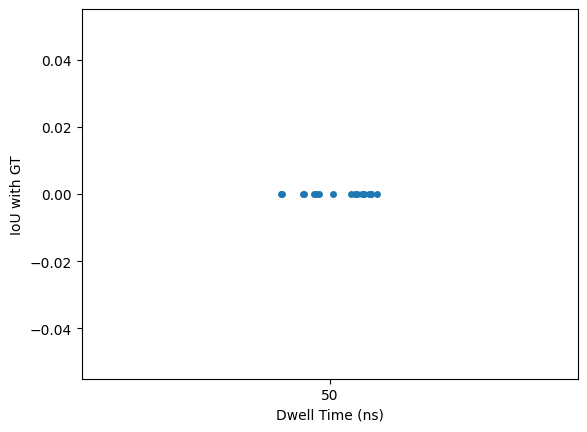

In [9]:
data = {"Dwell Time (ns)": data_dwts, "IoU with GT": data_gt_ious, "IoU with 1200ns": data_hdt_ious}
df = pd.DataFrame(data=data)
sns.stripplot(data=df, y="IoU with GT", x="Dwell Time (ns)")

<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from GT (nats)'>

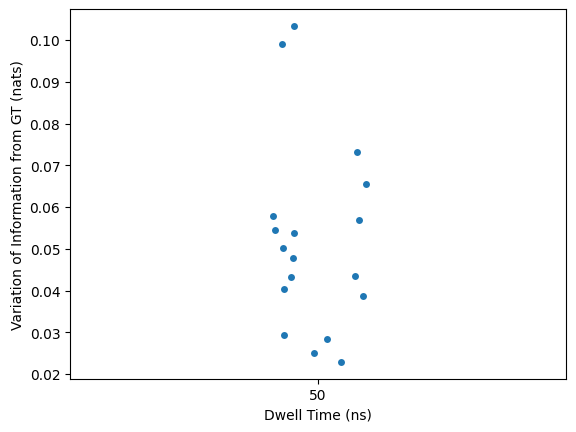

In [28]:
sns.stripplot(data=df, y="Variation of Information from GT (nats)", x="Dwell Time (ns)")

# Visualize result

In [13]:
images = {}

desired_dwts = [50] #[25, 50, 100, 400, 800, 1200]

with h5py.File(data_path, "r") as f:
    reg = list(f.keys())[2]
    group = f[reg]

    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]
    
    gt_mask = group[f"{slowest_dwt}/mask"][()]
    gt_mask_masked = np.ma.masked_where(gt_mask == 0, gt_mask)
    frac_rescan = np.sum(gt_mask > 0) / gt_mask.size

    for dwt in desired_dwts:
        im = group[f"{dwt}/im"][()]

        mask, probs = get_prediction(im, model)

        mask_masked = np.ma.masked_where(mask == 0, mask)

        voi,_,_ = pyvoi.VI(gt_mask.flatten(), mask.flatten())
        title_stem = f"{dwt}ns_VOI_{voi.item():.2f}"

        print(f"{probs.shape} {probs.dtype} {np.amin(probs)}-{np.median(probs)}-{np.amax(probs)}")
        images[title_stem + "_image"] = im
        images[title_stem + "_label"] = mask_masked
        pctile = np.percentile(probs.flatten(), (1-frac_rescan)*100)
        images[title_stem + "_pred"] = probs > pctile


images["ground_truth_image"] = im
images["ground_truth_label"] = gt_mask_masked
images["ground_truth_pred"] = gt_mask
images["high_dwell_time_image"] = im


(1632, 1920) float32 0.0-0.0-0.9970884919166565


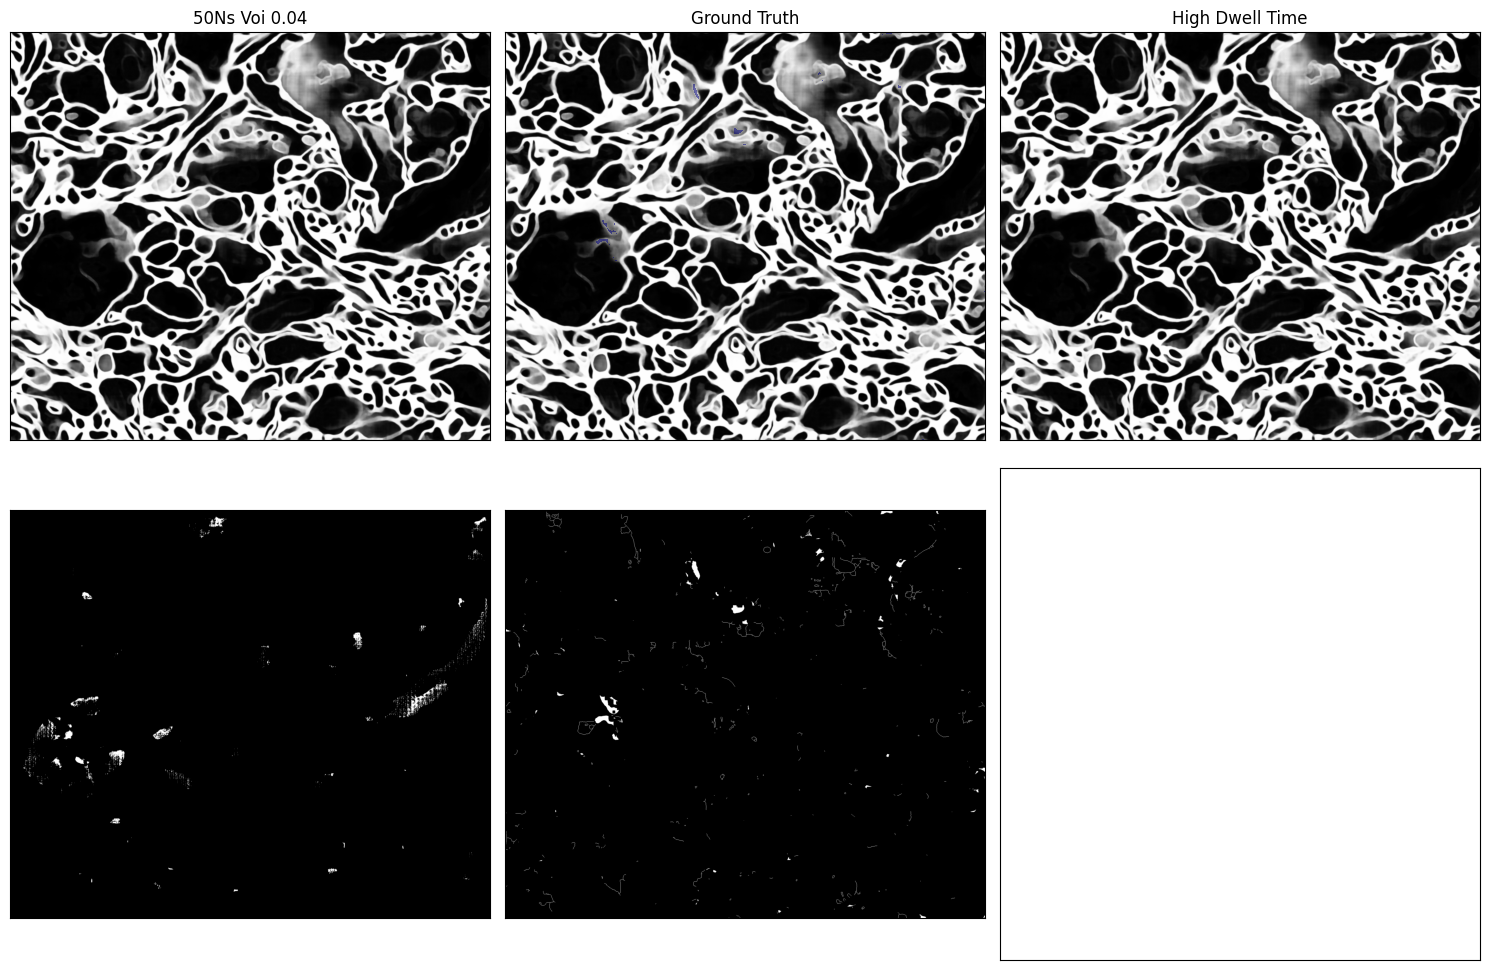

In [14]:
utils.visualize(**images)